In [ ]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import fill_short_false_runs


In [ ]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

In [ ]:
from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [ ]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Postprocessing_Py\\.venv\\Lib\\site-packages\\cupy\\__init__.py'>


In [ ]:
# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json


In [ ]:


def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)


In [ ]:

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0



file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\1.cine")
# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=80)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels

F, H, W = video.shape



if gamma != 1.0:
    video = video ** gamma

json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\config.json")
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")



Video Info - Width: 768, Height: 768, Frames: 80
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


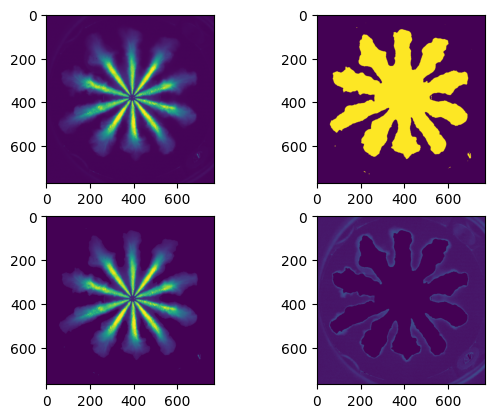

In [ ]:
px_range_map = cp.max(video, axis=0) - cp.min(video, axis=0)


mask, _ = triangle_binarize_from_float(to_numpy(px_range_map))
# mask = keep_largest_component(mask)
mask = binary_fill_holes(mask)
mask = cp.asarray(mask)


# Visualize max pixel range of each pixel in the video vs the mask made out of it
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(_as_numpy(px_range_map))
ax[0,1].imshow(_as_numpy(mask))
ax[1,0].imshow(_as_numpy((mask*px_range_map)))
ax[1,1].imshow(_as_numpy((px_range_map*(1- mask))))
# fig.set_title("Max pixel range of each pixel in the video vs the mask made out of it")


In [ ]:
def generate_ring_mask(H, W, centre, ir_, or_, xp):
    """
    Generates a boolean mask for a ring defined by inner and outer radii.
    
    Parameters:
    -----------
    H, W : int
        Height and Width of the image/mask.
    centre : tuple
        (x, y) coordinates of the center.
    ir_ : float
        Inner radius.
    or_ : float
        Outer radius.
    xp : module
        The array module to use (numpy or cupy).
        
    Returns:
    --------
    mask : xp.ndarray
        Boolean mask where True indicates pixels within the ring.
    """
    # Create a grid of (y, x) coordinates
    y, x = xp.indices((H, W))
    
    # Calculate the squared distance from the centre
    # centre is (x, y)
    dx = x - centre[0]
    dy = y - centre[1]
    dist_sq = dx**2 + dy**2
    
    # Create the mask where distance is between ir_ and or_
    # Using squared distances avoids computing square roots for efficiency
    mask = (dist_sq >= ir_**2) & (dist_sq <= or_**2)
    
    return mask


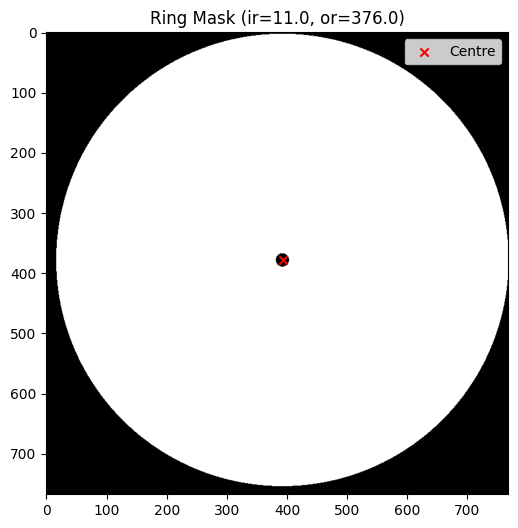

In [ ]:

# --- Usage Example ---

# Generate the ring mask
ring_mask = generate_ring_mask(H, W, centre, ir_, or_, xp)

# Visualize the mask
plt.figure(figsize=(6, 6))
plt.imshow(_as_numpy(ring_mask), cmap='gray')
plt.scatter(centre[0], centre[1], c='red', marker='x', label='Centre')
plt.title(f"Ring Mask (ir={ir_}, or={or_})")
plt.legend()
plt.show()

# Optional: Combine with the angular mask from the previous step
# combined_mask = ring_mask & angular_mask
# plt.figure(figsize=(6, 6))
# plt.imshow(_as_numpy(combined_mask), cmap='gray')
# plt.title("Combined Ring and Angular Mask")
# plt.show()


In [ ]:
# Apply the ring mask

video *= ring_mask[None, : ,:]

Text(0.5, 1.0, 'Gain compensation for the background image')

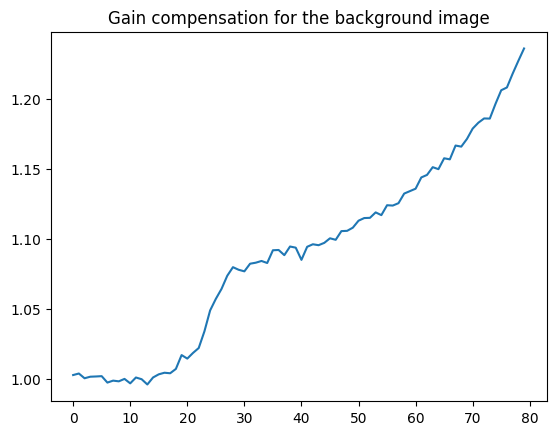

In [ ]:
# visualize the masked video

frames_before_SOI = 15

bkg_gain_curve = (video*cp.asarray((1-mask)[None, :, :])).sum(axis=(1,2)) / (H * W * 1.0)

bkg_gain_curve /= xp.mean(bkg_gain_curve[:frames_before_SOI])

plt.plot(bkg_gain_curve.get())

plt.title("Gain compensation for the background image")

In [ ]:
# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(video, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(video), 7, 3, 3)



# Take the filtered first frame as background 
bkg = cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9


# dynamic_bkg = bkg_gain_curve[:, None, None]*(cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)[None, :, :])
bkg = (cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)[None, :, :])

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bkg
# foreground *= mask[None, :, :]


In [ ]:
play = True
if play:
    # Visualize the filtering results
    # play_video_cv2(video.get())
    play_videos_side_by_side((video.get(), bilateral_filtered.get(), foreground.get()), intv=100) # type: ignore


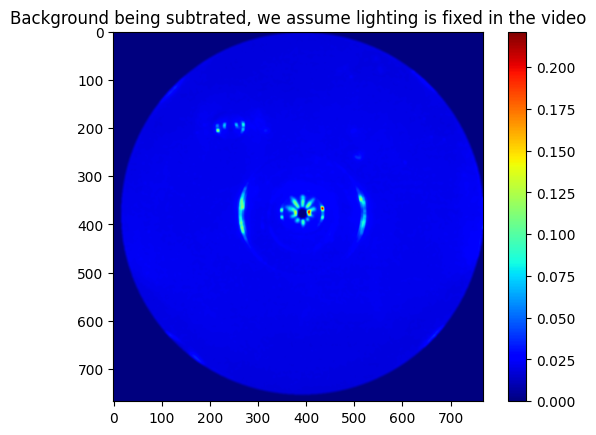

In [ ]:
plt.title("Background being subtrated, we assume lighting is fixed in the video")
plt.imshow(_as_numpy(bkg).squeeze(), cmap="jet")
plt.colorbar()

(392.498, 378.372)

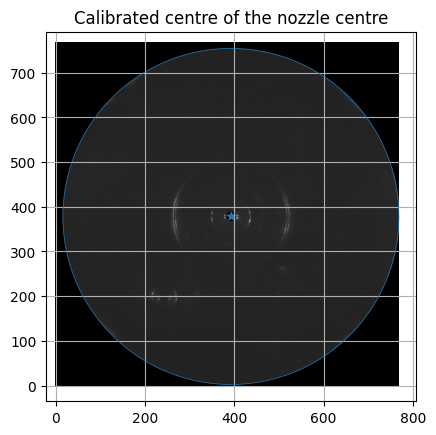

In [ ]:
r = or_

# Displaying the clibration
plt.imshow(video[0].get()**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="0.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([centre[0]-1.1*r, centre[0]+1.1*r])
plt.ylim([centre[1]-1.1*r, centre[1]+1.1*r])
plt.title("Calibrated centre of the nozzle centre")
centre

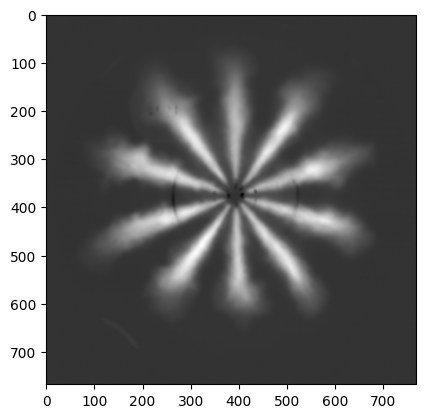

In [ ]:
foreground_summed = xp.sum(foreground, axis=0)
plt.imshow(_as_numpy(foreground_summed), cmap="gray")



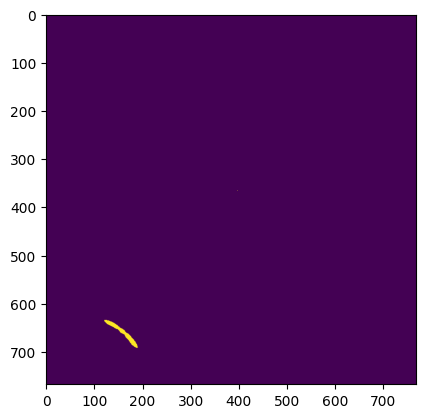

In [ ]:
# There is a spot in the chamber that needs to be masked 
sum_mask = _triangle_binarize_gpu(foreground_summed)

reflection_mask = keep_largest_component_cuda(sum_mask)

spot_mask = sum_mask ^ reflection_mask
plt.imshow(_as_numpy(spot_mask))

foreground *= (1- spot_mask)[None, :, :]

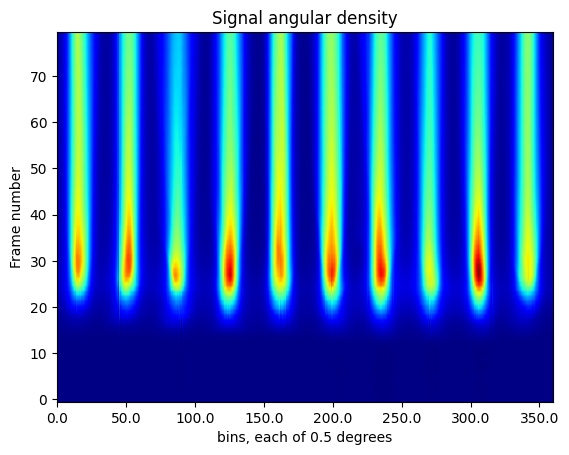

In [ ]:
bins = 720

scale = bins/360.0


fig, ax = plt.subplots()


_, signal, _ = angle_signal_density_auto(foreground, centre[0], centre[1], N_bins=bins)

plt.imshow(_as_numpy(signal), aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)

Estimated offset from FFT: 16.956 degrees


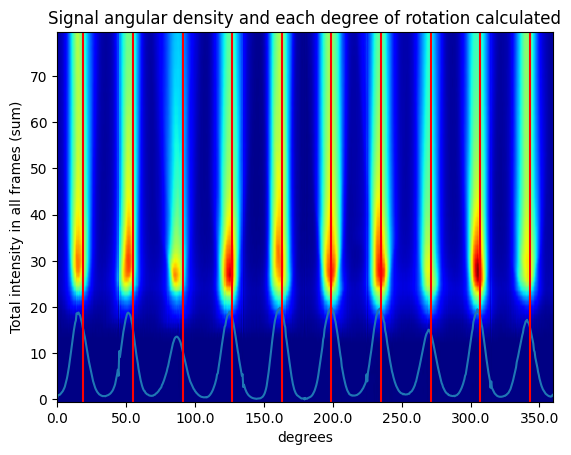

In [ ]:
# Offset is calculated by the sum of angular signal in all frames
# (See the blue curve below)
# And setting the fundamental frequency to *number of plumes*,
# Find the best offset for this periodicity 

offset = estimate_offset_from_fft(signal, number_of_plumes)
if offset:
    print(f"Estimated offset from FFT: {offset:.3f} degrees")




angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)


# foreground = xp.asarray(foreground, dtype=xp.float32)
summed_angular_density_all_frames = np.sum(signal, axis=0)


fig, ax = plt.subplots()
plt.plot(_as_numpy(_min_max_scale(summed_angular_density_all_frames))*20)

plt.imshow(_as_numpy(_min_max_scale(signal)), aspect="auto", origin="lower", cmap="jet")
shift = np.sum(angles < 0) * 360.0/number_of_plumes

for idx, angle in enumerate(angles):
    plt.axvline((bins/360.0)*(angle+shift), color="r")

plt.title("Signal angular density and each degree of rotation calculated")
plt.xlabel(f"degrees")
plt.ylabel("Total intensity in all frames (sum)")

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)
    

In [ ]:
TF = triangle_binarize_gpu(cp.sum(signal, axis=0))
TF = fill_short_false_runs(TF, max_len=3)


20.599999999999998

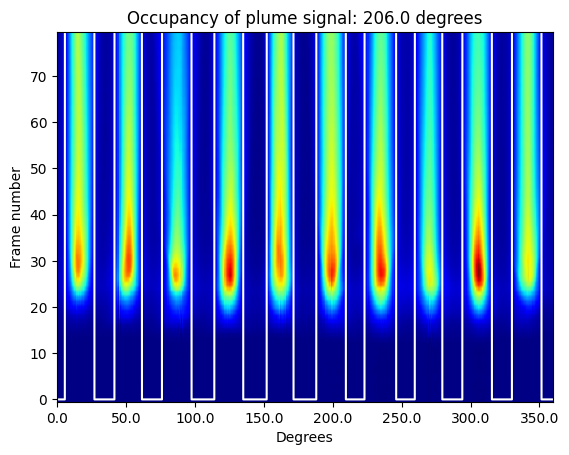

In [ ]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()



scale = 2
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)

ax.plot(TF.get()*signal.shape[1], color="w")
ax.imshow(signal.get(), aspect="auto", origin="lower", cmap="jet")

# plt.plot(_as_numpy(_min_max_scale(summed_angular_density_all_frames)*1))


TF.sum()/bins*360.0

ax.set_ylabel("Frame number")
ax.set_xlabel("Degrees")

ax.set_title(f"Occupancy of plume signal: {TF.sum()/bins*360.0:.1f} degrees")

average_cone_angle = (TF.sum()/bins/number_of_plumes*360.0).item()
average_cone_angle

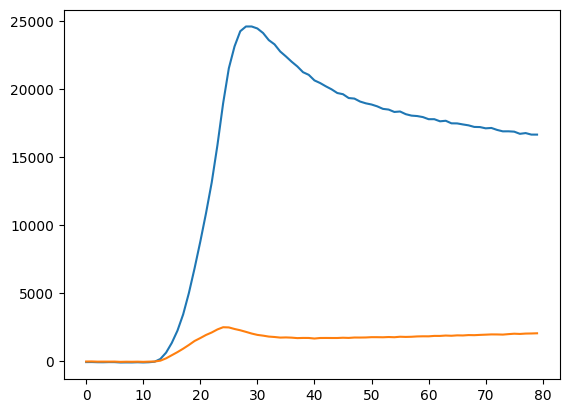

In [ ]:
plt.plot(_as_numpy(xp.sum(TF*signal, axis=1)))

plt.plot(_as_numpy(xp.sum((1-TF)*signal, axis=1)))

In [ ]:
def generate_angular_mask_from_tf(H, W, centre, TF, bins):
    """
    Generates a 2D mask where pixels are set to the value of TF 
    corresponding to their angular bin relative to the centre.
    """
    # Create a grid of (y, x) coordinates
    # xp is cupy or numpy depending on your backend configuration
    y, x = xp.indices((H, W))
    
    # Calculate the difference from the centre
    # centre is (x, y)
    dx = x - centre[0]
    dy = y - centre[1]
    
    # Calculate angles in degrees [0, 360)
    # arctan2 returns values in [-pi, pi]
    angles = xp.degrees(xp.arctan2(dy, dx))
    angles = (angles + 360) % 360
    
    # Convert angles to bin indices
    # bins is the total number of angular bins (e.g., 720)
    bin_indices = (angles / 360.0 * bins).astype(xp.int32)
    
    # Handle edge case where angle is exactly 360 (though modulo usually handles this)
    bin_indices = xp.clip(bin_indices, 0, bins - 1)
    
    # Create the mask by indexing the TF array with the bin indices
    # If TF is 1 for plume and 0 for background, this mask will be 1 for plume pixels.
    mask = TF[bin_indices]
    
    return mask


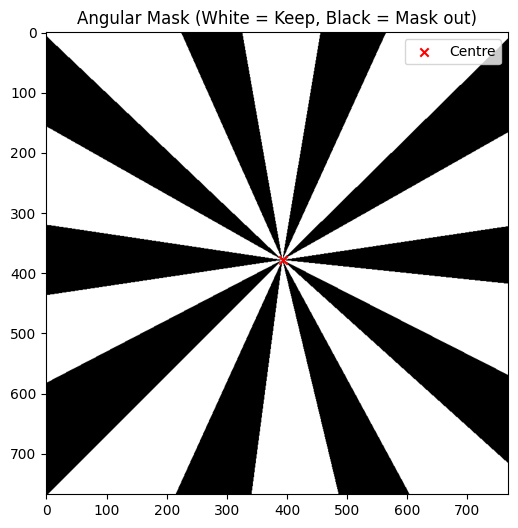

In [ ]:

# Generate the mask
F, H, W = video.shape
angular_mask = generate_angular_mask_from_tf(H, W, centre, TF, bins)

# Visualize the resulting mask
plt.figure(figsize=(6, 6))
plt.imshow(_as_numpy(angular_mask), cmap='gray')
plt.scatter(centre[0], centre[1], c='red', marker='x', label='Centre')
plt.title("Angular Mask (White = Keep, Black = Mask out)")
plt.legend()
plt.show()

# Example: Apply mask to the first frame of the video to verify
# masked_frame = video[0] * angular_mask
# plt.figure()
# plt.imshow(_as_numpy(masked_frame), cmap='gray')
# plt.title("Masked Frame")
# plt.show()


In [ ]:
foreground *= angular_mask[None, :, :]
if play:
    play_video_cv2(_as_numpy(foreground))

In [ ]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            foreground,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)


segments = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)
segments = xp.clip(segments, 0.0, 1.0).astype(xp.float16)

In [ ]:
if play:
    play_videos_side_by_side((cp.swapaxes(segments, 2, 3)).get().tolist())

In [ ]:
def generate_angular_mask(w, h, angle=None, x0=0, y0=None):

    if y0 is None:
        y0 = h/2

    if angle is None:
        y1 = 0
        y2 = h
    else:
        half_angle_radian = angle / 2.0 * np.pi/180.0
        y1 = -w * np.tan(half_angle_radian) + h/2
        y2 = w * np.tan(half_angle_radian) + h/2

    # Create blank single-channel mask of same height/width
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define polygon vertices as Nx2 integer array  
    pts = np.array([[x0, y0], [w, y1], [w, y2]], dtype=np.int32)
    
    # Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], (255,))

    # cv2.imshow("plume_mask", mask) # Debug

    # Apply mask to extract polygon region
    return mask >0 

In [ ]:
def generate_angular_mask(w, h, angle=None, x0=0, y0=None):

    if y0 is None:
        y0 = h/2

    if angle is None:
        y1 = 0
        y2 = h
    else:
        half_angle_radian = angle / 2.0 * np.pi/180.0
        y1 = -w * np.tan(half_angle_radian) + h/2
        y2 = w * np.tan(half_angle_radian) + h/2

    # Create blank single-channel mask of same height/width
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define polygon vertices as Nx2 integer array  
    pts = np.array([[x0, y0], [w, y1], [w, y2]], dtype=np.int32)
    
    # Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], (255,))

    # cv2.imshow("plume_mask", mask) # Debug

    # Apply mask to extract polygon region
    return mask >0 

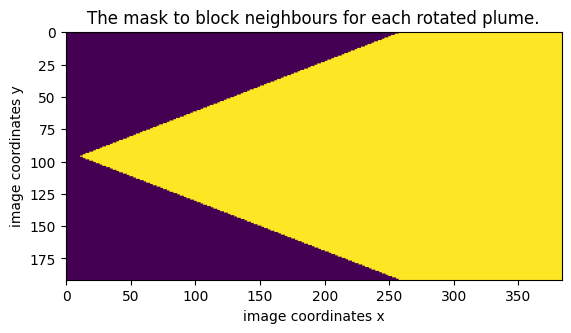

In [ ]:

# plume_mask = generate_plume_mask(0, or_, segments.shape[3], segments.shape[2])
plume_mask = generate_angular_mask(segments.shape[3], segments.shape[2], angle=average_cone_angle*2, x0=ir_)
plt.imshow(plume_mask)
plt.title("The mask to block neighbours for each rotated plume.")
plt.xlabel("image coordinates x")
plt.ylabel("image coordinates y")

# plume_mask.shape
plume_mask_width = plume_mask.sum(axis=0)
# plt.plot(plume_mask_width)

In [ ]:
# Array shape fitting and upload to the GPU
angular_masks = cp.asarray(plume_mask[None, None, :, :])

# Apply the rotated masks
# segments_masked = angular_masks*range_masks*segments
segments_masked = angular_masks*segments



In [ ]:

# Show a random segment
# idx = np.random.random_integers(0, segments_masked.shape[0]-1)
# play_video_cv2(segments_masked[idx].get())

# Show all rotated plumes
if play:
    play_videos_side_by_side((cp.swapaxes(segments_masked, 2, 3)).get().tolist())

In [ ]:
# Crop the rotated segments, from calibrated nozzle center to upper limit by the window
segments_corrected = segments_masked[:, :, :, int(ir_): int(or_)]

P, F, H, W = segments_corrected.shape

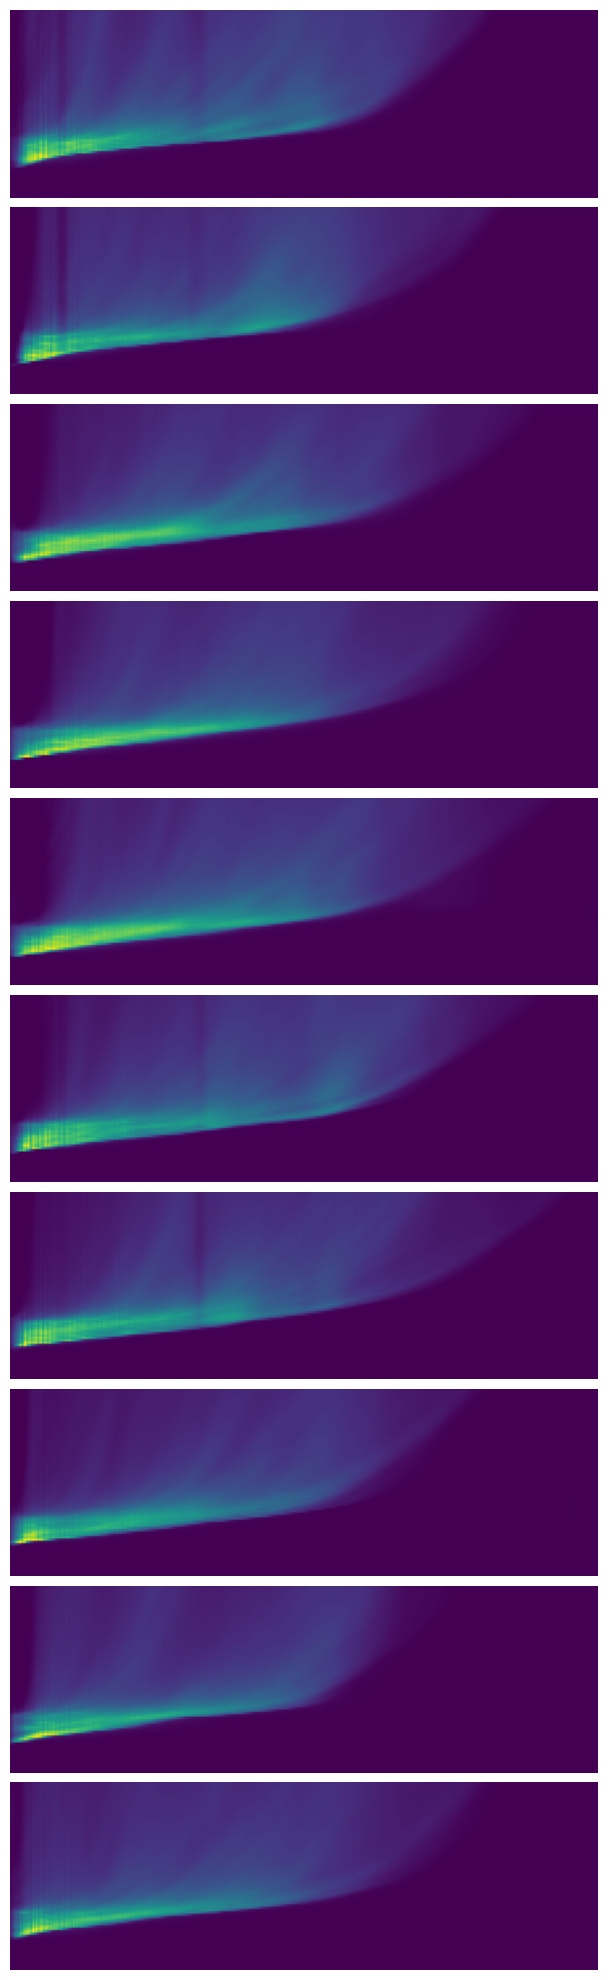

In [ ]:
time_distance_intensity_maps = xp.sum(segments_corrected, axis=2)/segments_corrected.shape[2]/cp.asarray(plume_mask_width[None, None, int(ir_): int(or_)])

# for p in range(P):
#     time_distance_intensity_maps[p] = _min_max_scale(time_distance_intensity_maps[p])


n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

for idx, td_map in enumerate(time_distance_intensity_maps):
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")

for a in ax:
    a.set_xticks([])    
    a.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()
# ax.set_title("Bruh")

In [ ]:
def imhists(images, bins=1000, log=False, exclude_zero=False):
    """
    Plot histogram (and implicitly CDF via cumulated counts if desired) of image data.
    
    Parameters
    ----------
    image : array-like
        Input image values expected in [0, 1].
    bins : int
        Number of histogram bins.
    log : bool
        If True, use logarithmic y-axis.
    exclude_zero : bool
        If True, filter out zero-valued pixels before computing histogram.
    """
    
    fig, ax = plt.subplots()
    for image in images:
        # Flatten image
        data = image.ravel()
        if exclude_zero:
            data = data[data != 0]
        
        hist, edges = np.histogram(data, bins=bins, range=(0, 1))
        centers = (edges[:-1] + edges[1:]) / 2

        
        ax.plot(centers, hist, lw=1.2)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)  # avoid log(0) issues
    ax.set_xlabel("Range value")
    ax.set_ylabel("Count" + (" (log scale)" if log else ""))
    ax.set_title("Histogram of image" + (" (zeros excluded)" if exclude_zero else ""))
    ax.grid(True, which='both', ls='--', alpha=0.3)
    plt.show()

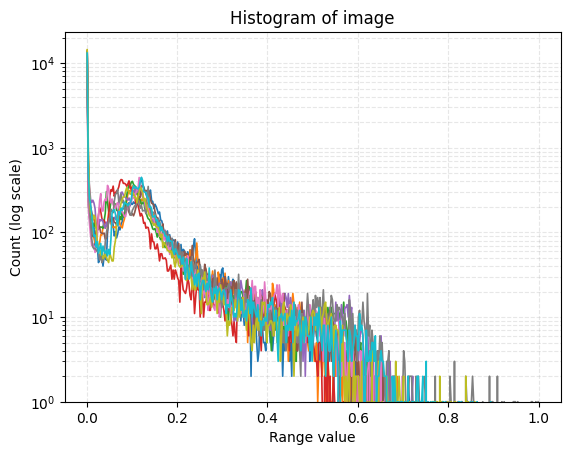

In [ ]:
imhists(_min_max_scale(time_distance_intensity_maps).get(), bins=400,log=True, exclude_zero=False)

In [ ]:
frame_wise_sums = xp.sum(time_distance_intensity_maps, axis=-1)/time_distance_intensity_maps.shape[-1]

brightness_peaks = xp.argmax(frame_wise_sums, axis=1)
peak_intensity_sums = xp.max(frame_wise_sums, axis=1)

frame_wise_sums /= peak_intensity_sums[:, None]

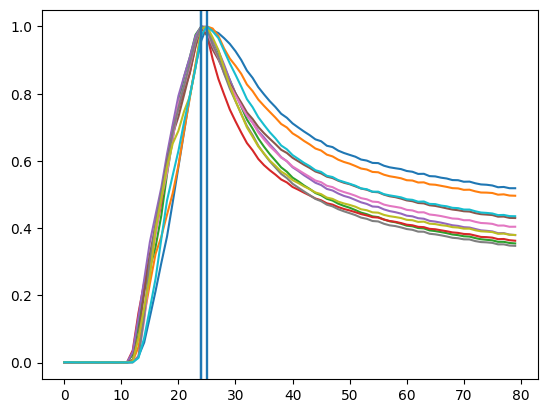

In [ ]:
plt.plot(frame_wise_sums.T.get())
for idx in brightness_peaks.get():
    plt.axvline(idx)

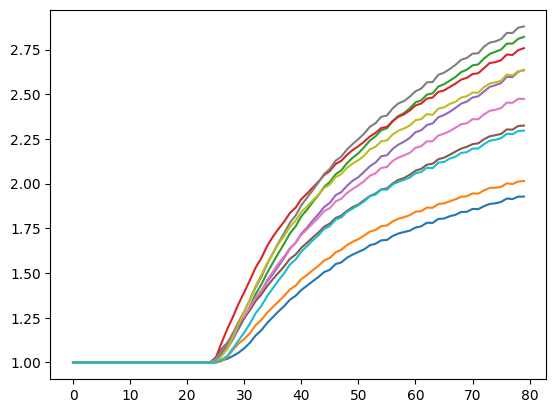

In [ ]:
gain_curves = cp.ones_like(frame_wise_sums)
eps = 1e-9
for idx, frame_wise_sum in enumerate(frame_wise_sums):
    gain_curves[idx, int(brightness_peaks[idx]):] = 1.0/(eps+frame_wise_sum[int(brightness_peaks[idx]):])


plt.plot(gain_curves.T.get())

td_map_gain_compensated = time_distance_intensity_maps * gain_curves[:, :, None]

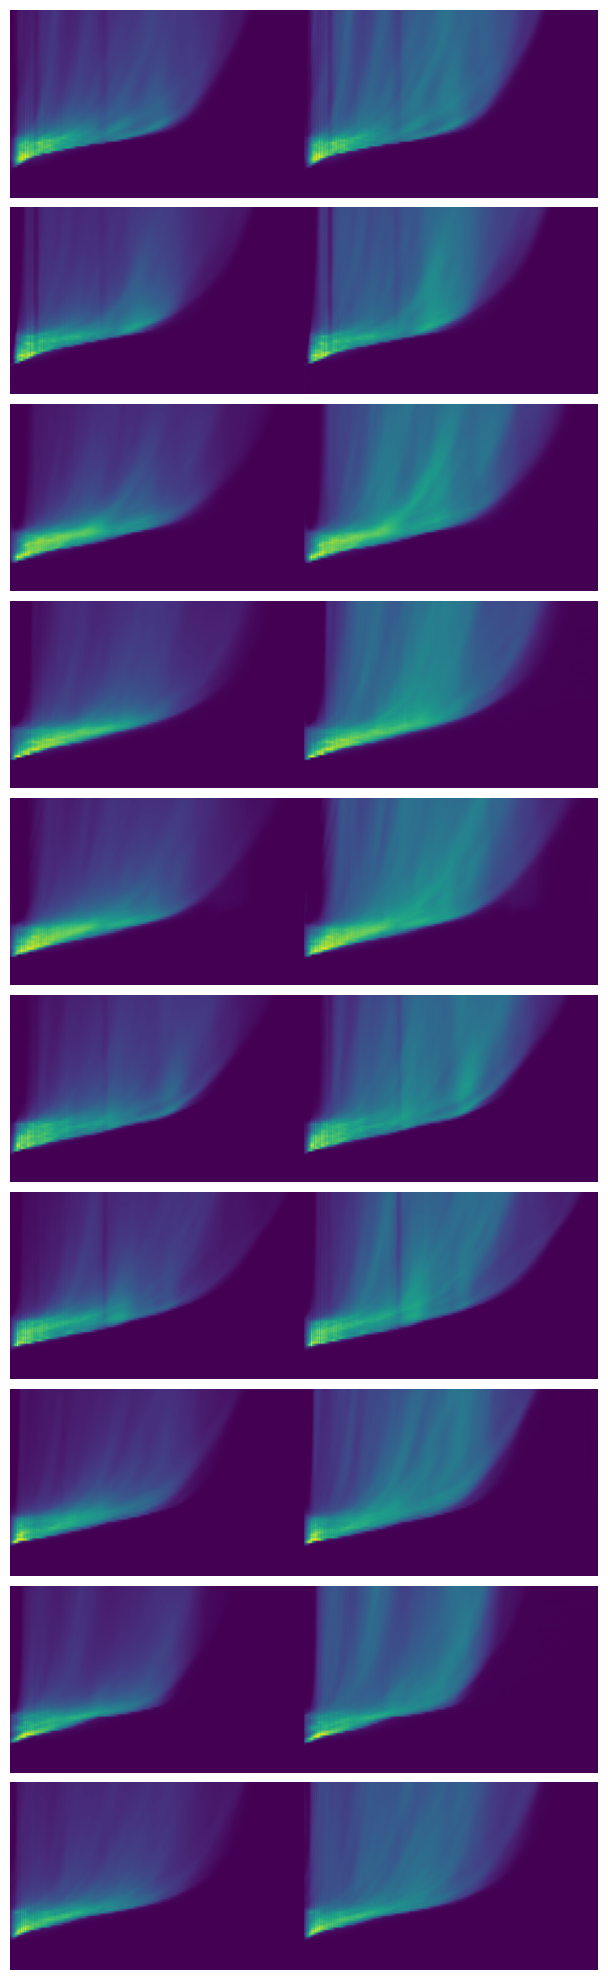

In [ ]:

import matplotlib.pyplot as plt

n = len(time_distance_intensity_maps)

# 1. 调整 figsize：根据你的数据长宽比适当调整，或者保持现状
# 2. gridspec_kw：直接在创建时指定间距为0
fig, ax = plt.subplots(
    n, 2, 
    figsize=(6, 2.0 * n), 
    sharex=True,
    sharey=True,  # 建议加上 sharey，如果两列数据Y轴物理意义一致
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

# 展平 ax 数组方便遍历，处理 n=1 的特殊情况
if n == 1: ax = ax.reshape(1, -1)

for idx, (map_left, map_right) in enumerate(zip(time_distance_intensity_maps, td_map_gain_compensated)):
    # 3. 关键：aspect='auto' 填满格子
    ax[idx, 0].imshow(map_left.get(), origin="lower", aspect='auto')
    ax[idx, 1].imshow(map_right.get(), origin="lower", aspect='auto')

    # 4. 关闭坐标轴显示（比 set_xticks([]) 更彻底，连边框都会去掉，看起来更像一个整体）
    # 如果你想保留边框但去掉刻度，继续用你原来的方法
    ax[idx, 0].axis('off')
    ax[idx, 1].axis('off')

# 5. 去除画布边缘的额外空白
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()

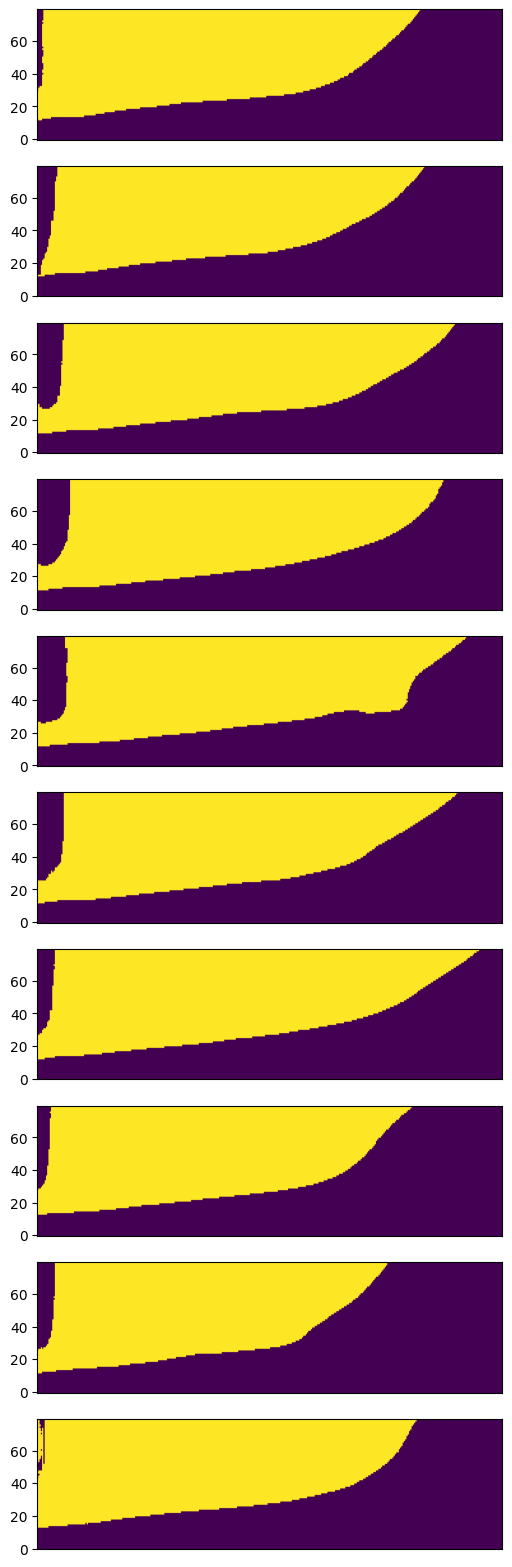

In [ ]:
P, F, H, W = segments_corrected.shape
penetration_bw_td = cp.zeros((P, F, W))
penetration_td = cp.zeros((P, F))


for p in range(P):
    # for f in range(F-1):
    #     penetration_bw_td[p, f, :] =  triangle_binarize_gpu(time_distance_intensity_maps[p, f])
    penetration_bw_td[p] =  keep_largest_component_cuda(
            triangle_binarize_gpu(
                # time_distance_intensity_maps[p])
                td_map_gain_compensated[p])
                , connectivity=2)
    

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True
)

for idx, td_map in enumerate(penetration_bw_td):
    # ax[idx].imshow(td_map.get()*td_map_gain_compensated[idx].get(), origin="lower")
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

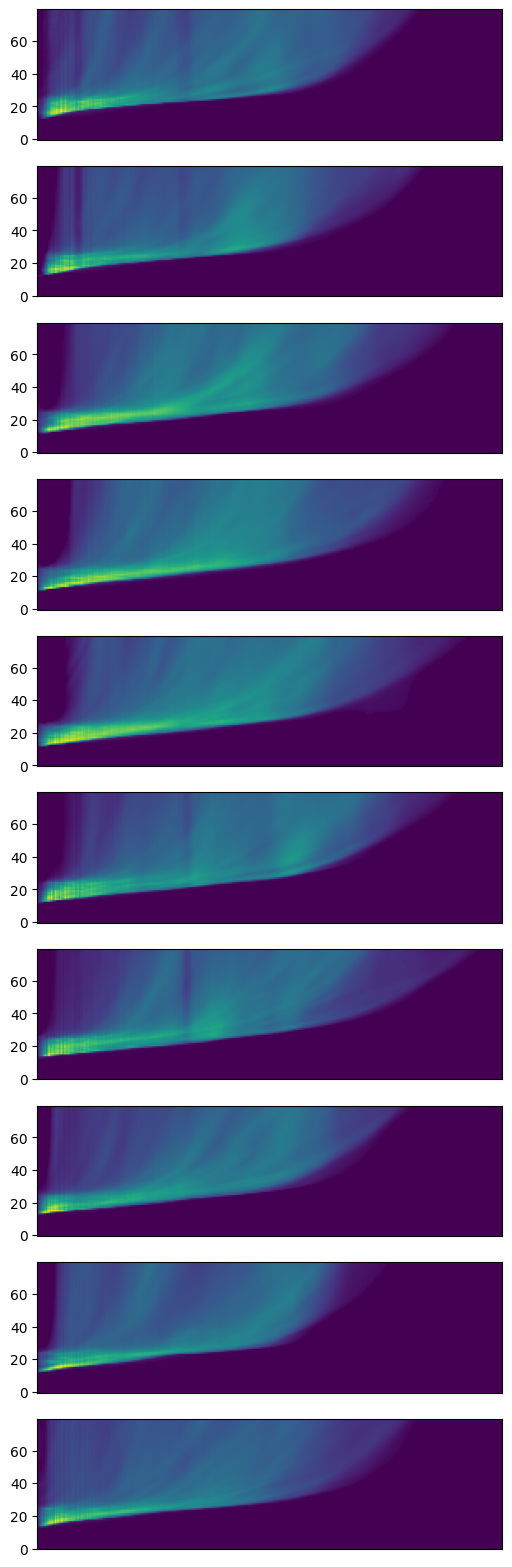

In [ ]:
n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True
)

for idx, bw_map in enumerate(penetration_bw_td):
    ax[idx].imshow(bw_map.get()*td_map_gain_compensated[idx].get(), origin="lower", aspect="auto")


for a in ax[:-1]:
    a.set_xticks([])

In [ ]:
def monotone_non_decreasing(x):
    return np.maximum.accumulate(x)


def penetration_cdf_front(I, mask=None, q=0.97, min_x=0):
    """
    I: (T,X)
    mask: (T,X) {0,1} 可选，只在喷雾区域内累计
    q: cumulative quantile, e.g. 0.95~0.995
    """
    I = np.asarray(I, np.float32)
    T, X = I.shape

    # 每帧背景抹掉：用分位数当背景（比中位数更适合你这种“大片暗背景+亮喷雾”）
    bg = np.quantile(I, 0.10, axis=1, keepdims=True)
    S = I - bg
    S[S < 0] = 0

    if mask is not None:
        S = S * mask.astype(np.float32)

    S[:, :min_x] = 0

    cdf = np.cumsum(S, axis=1)
    tot = cdf[:, -1] + 1e-6
    target = q * tot

    xhat = np.argmax(cdf >= target[:, None], axis=1).astype(np.int32)
    # 若某帧 tot≈0（几乎没亮度），argmax 会返回 0；你可后处理
    return xhat



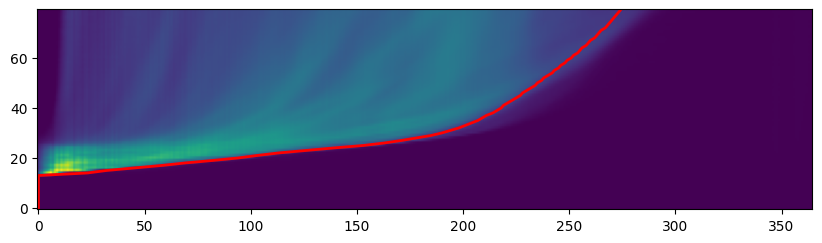

In [ ]:
idx = 7
I = td_map_gain_compensated[idx].get()
mask = penetration_bw_td[idx].get()
mask = 1-(keep_largest_component(1-mask))

xhat = penetration_cdf_front(I, mask=mask, q=0.97, min_x=8)
pen0 = monotone_non_decreasing(xhat)

plt.figure(figsize=(10,2.6))
plt.imshow(I, origin="lower", aspect="auto")
plt.plot(pen0, np.arange(I.shape[0]), 'r-', lw=2)
plt.show()


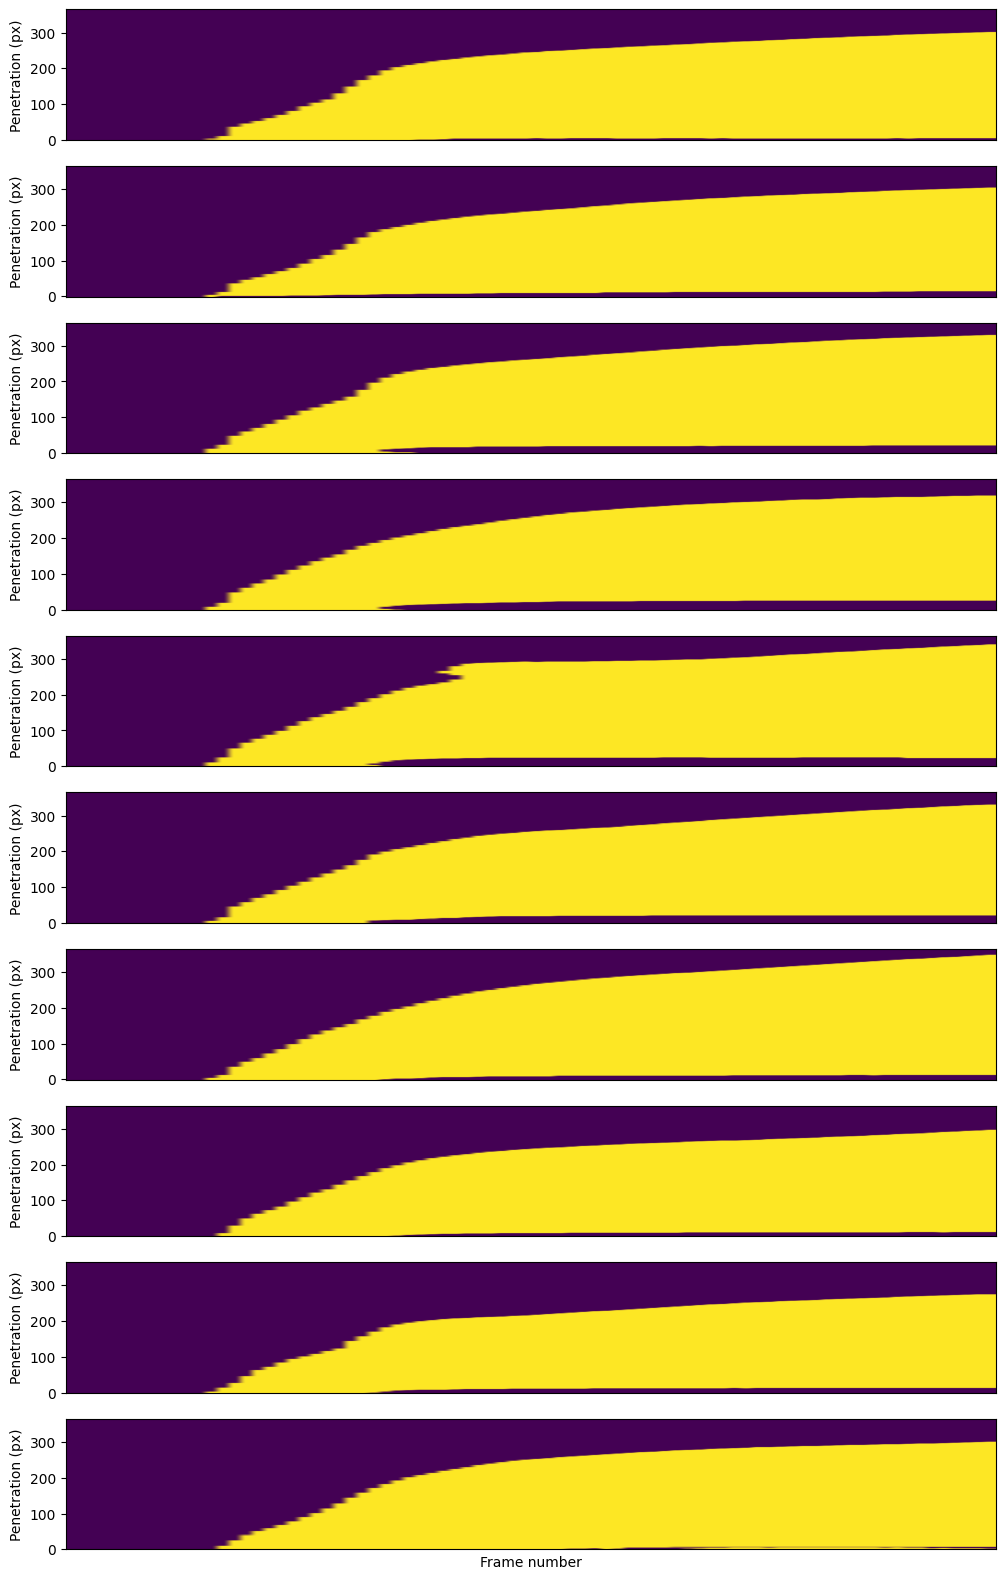

In [ ]:
penetration_bw_td_T = cp.swapaxes(penetration_bw_td, 1,2)

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(12, 20),   # ← critical line
    sharex=True
)

for idx, td_map in enumerate(penetration_bw_td_T):
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    ax[idx].set_ylabel("Penetration (px)")

ax[idx].set_xlabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

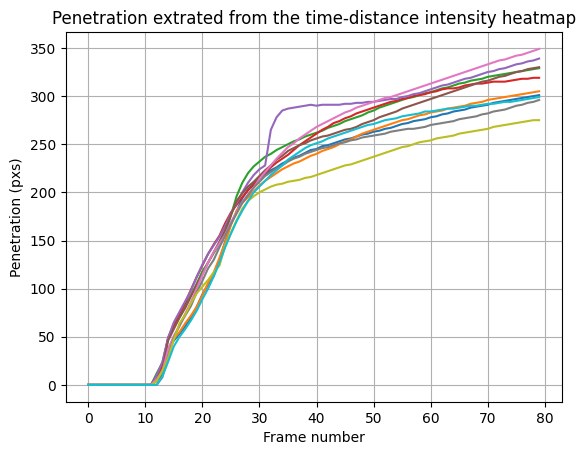

In [ ]:
# penetration_bw_td_T has shape (Plume, Width, Frame)

penetration_td = penetration_bw_td_T.shape[1] - cp.argmax(penetration_bw_td_T[:, ::-1, :], axis=1)
penetration_td = penetration_td.astype(cp.float32)  # 或 cp.float64
# penetration_td[penetration_td == penetration_bw_td_T.shape[1]] = cp.nan

penetration_td *= contrast_TF
# penetration_td[penetration_td==0.0] = cp.nan 

plt.plot(penetration_td.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()



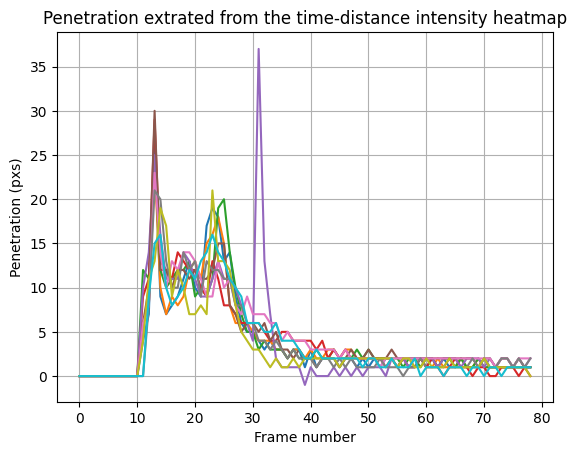

In [ ]:
penetration_diff = xp.diff(penetration_td)
plt.plot(penetration_diff.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()

'\n# Robust center/scale per column (axis=0)\nmed = xp.nanmedian(penetration_diff, axis=0)\n\nabs_dev = xp.abs(penetration_diff - med)\nmad = xp.nanmedian(abs_dev, axis=0)\n\n# MAD -> robust std (Gaussian-consistent): sigma ~= 1.4826 * MAD\nsigma = 1.4826 * mad\nsigma_safe = xp.where(sigma == 0, 1, sigma)\n\nz = (penetration_diff - med) / sigma_safe\n\n# Dynamic threshold k(med): wide when med small, tight when med big\nk_min = 5.0     # 大 med 时的最严阈值（可调）\nk_max = 16.0     # 小 med 时的最松阈值（可调）\nm0 = xp.nanmedian(xp.abs(med)) + 1e-12  # 转折尺度：也可以手动设成你想要的量级\n\nk = k_min + (k_max - k_min) * (m0 / (xp.abs(med) + m0))   # shape (W,)\nk = k[None, :]  # broadcast to (H, W) if penetration_diff is (H, W)\n\nmask_out = xp.abs(z) > k\nx_loc, y_loc = xp.where(mask_out)\n\n# 可视化（你原来的）\n# plt.plot(_as_numpy(z_scores).T)   # <- 你原来用 z_scores，这里换成 z\n# 建议：把 outlier 点也画出来（可选）\nplt.scatter(_as_numpy(y_loc), _as_numpy(x_loc), s=2)\n'

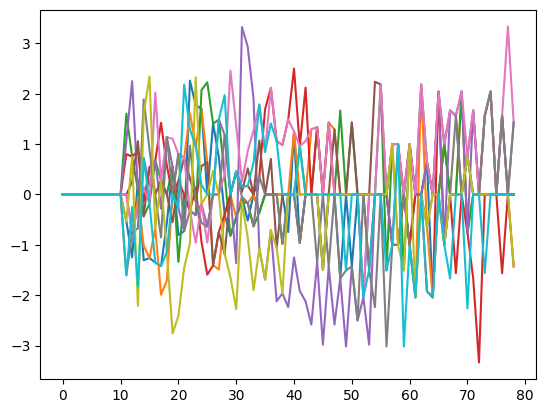

In [ ]:

# Removing outliers via z-score
med = xp.nanmedian(penetration_diff, axis=0)
std = xp.nanstd(penetration_diff, axis=0)
std_safe = xp.where(std == 0, 1, std)
z_scores = (penetration_diff - med) / std_safe

x_loc, y_loc = xp.where(xp.abs(z_scores) > 3)
plt.plot(_as_numpy(z_scores).T)
"""
# Robust center/scale per column (axis=0)
med = xp.nanmedian(penetration_diff, axis=0)

abs_dev = xp.abs(penetration_diff - med)
mad = xp.nanmedian(abs_dev, axis=0)

# MAD -> robust std (Gaussian-consistent): sigma ~= 1.4826 * MAD
sigma = 1.4826 * mad
sigma_safe = xp.where(sigma == 0, 1, sigma)

z = (penetration_diff - med) / sigma_safe

# Dynamic threshold k(med): wide when med small, tight when med big
k_min = 5.0     # 大 med 时的最严阈值（可调）
k_max = 16.0     # 小 med 时的最松阈值（可调）
m0 = xp.nanmedian(xp.abs(med)) + 1e-12  # 转折尺度：也可以手动设成你想要的量级

k = k_min + (k_max - k_min) * (m0 / (xp.abs(med) + m0))   # shape (W,)
k = k[None, :]  # broadcast to (H, W) if penetration_diff is (H, W)

mask_out = xp.abs(z) > k
x_loc, y_loc = xp.where(mask_out)

# 可视化（你原来的）
# plt.plot(_as_numpy(z_scores).T)   # <- 你原来用 z_scores，这里换成 z
# 建议：把 outlier 点也画出来（可选）
plt.scatter(_as_numpy(y_loc), _as_numpy(x_loc), s=2)
"""


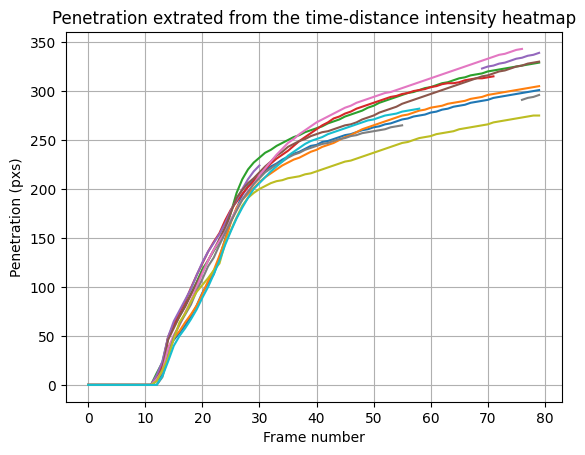

In [ ]:

for i in range(len(x_loc)):
    # pt = x_loc[i], y_loc[i]
    # penetration_diff[x_loc[i], y_loc[i]:] = xp.nan
    penetration_td[x_loc[i], y_loc[i]:y_loc[i]+20] = xp.nan

# plt.plot(penetration_diff.T.get())
plt.plot(penetration_td.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()


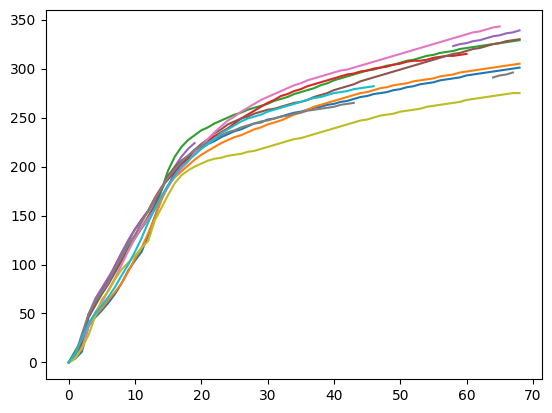

In [ ]:
penetration_td[penetration_td== 0] = xp.nan

hydrulic_delay = xp.nanargmin(penetration_td, axis=1)-1

penetration_copy = xp.zeros_like(penetration_td)

for i in range(P):
    arr = penetration_td[i][hydrulic_delay[i]:]
    arr[0] = 0.0
    plt.plot(arr.get())

In [ ]:
import numpy as np

fps = 25000
# px_mm_scale = df["px2mm_scale"][0] #To be calibrated later
px_mm_scale = 0.24
hydraulic_delay = 16

dataset = "median" # or "median"
USE_STD_WEIGHTS = False


In [ ]:

def build_fit_arrays(df_tp):
    t = 1.0 / fps * (df_tp["frame_number"].to_numpy(dtype=float) - hydraulic_delay)

    if dataset == "median":
        y = px_mm_scale * df_tp["penetration_median"].to_numpy(dtype=float)
    elif dataset == "mean":
        y = px_mm_scale * df_tp["penetration_average"].to_numpy(dtype=float)
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    if "penetration_std" in df_tp.columns and USE_STD_WEIGHTS:
        sigma = df_tp["penetration_std"].to_numpy(dtype=float)
        sigma = np.where(
            np.isfinite(sigma) & (sigma > 1e-9),
            sigma,
            np.nanmedian(sigma[np.isfinite(sigma) & (sigma > 0)])
        )
    else:
        sigma = np.ones_like(y)

    return t, y, sigma


In [ ]:
import numpy as np
from scipy.special import expit  # expit(x) = 1 / (1 + exp(-x))

# If you used a lower bound on tb before, keep it here
min_tb = 0.0 # change if you want a strictly positive minimum break time


def spray_penetration_model_sigmoid(params, t):
    """
    params (log-space): [log_c_lin, log_c_sqrt, log_tb, log_s]
        - c_lin  : effective linear-region gain (kv * sqrt(2*delta_p/rho_f))
        - c_sqrt : effective sqrt-region gain (kp * (delta_p/rho_a)**0.25 * sqrt(d))
        - tb     : break time (with lower bound min_tb)
        - s      : transition softness of the sigmoid

    t: array-like or float (time)
    """
    log_c_lin, log_c_sqrt, log_tb, log_s = params

    c_lin = np.exp(log_c_lin)
    c_sqrt = np.exp(log_c_sqrt)
    tb = np.exp(log_tb) + min_tb
    s = np.exp(log_s)

    # numerical guard
    t = np.clip(t, 1e-9, None)

    # Linear and sqrt asymptotes
    linear = c_lin * t
    sqrt_segment = c_sqrt * np.sqrt(t)

    # Sigmoid weight from sqrt side; (1-w) weights the linear side
    w = expit((t - tb) / s)

    return (1.0 - w) * linear + w * sqrt_segment


In [ ]:
from scipy.optimize import least_squares

init = {
    "kv": 1.0,
    "kp": 0.0,
    "tb": 1e-1,
    "s": 1.0,
}
x0 = np.log([init["kv"], init["kp"], init["tb"], init["s"]])


def fit_sigmoid(df_tp, return_arrays=False):
    t, y, sigma = build_fit_arrays(df_tp)

    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        result = {
            "log_params": np.full(4, np.nan),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }
        if return_arrays:
            result["t"] = t
            result["y"] = y
            result["sigma"] = sigma
        return result

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        return (y_hat - y_fit) / sigma_fit

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_kv, log_kp, log_tb, log_s = res.x
    result = {
        "log_params": res.x,
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }

    if return_arrays:
        result["t"] = t
        result["y"] = y
        result["sigma"] = sigma

    return result



init = {
    "kv": 1.0,
    "kp": 0.0,
    "tb": 1e-1,
    "s": 1.0,
}
x0 = np.log([init["kv"], init["kp"], init["tb"], init["s"]])


def fit_sigmoid(df_tp, return_arrays=False):
    t, y, sigma = build_fit_arrays(df_tp)

    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        result = {
            "log_params": np.full(4, np.nan),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }
        if return_arrays:
            result["t"] = t
            result["y"] = y
            result["sigma"] = sigma
        return result

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        return (y_hat - y_fit) / sigma_fit

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_kv, log_kp, log_tb, log_s = res.x
    result = {
        "log_params": res.x,
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }

    if return_arrays:
        result["t"] = t
        result["y"] = y
        result["sigma"] = sigma

    return result

